# Data Challenge ANCAP
Federica Bouvier, Sofia Borrazas, María del Pilar Nogues & Guillermo Robatto.

## Desafio
Lograr una estimación de la variable DQO en la Cámara de Aforo PTE a partir de los datos que se miden en forma continua, de forma de poder tomar acciones correctivas más rápidamente en caso de que se estimara que la variable no se encuentra en rango aceptable, sin tener que esperar a contar con los resultados de los análisis químicos correspondientes. Un efluente con alta DQO puede tener efectos perjudiciales significativos en la calidad del agua y en la salud de los ecosistemas acuáticos, de allí el interés en mejorar el control de dicha variable para mantenerla en rango aceptable.


### Registros disponibles

#### a)      Archivo con Datos continuos de la cámara de aforo

Se cuenta con registros conteniendo datos determinados automáticamente a intervalos de un minuto. Se dispone de más de cuatro años de registros automáticos continuos aproximadamente.

#### b)      Datos diarios cámara aforo PTE (Planta de Tratamiento de Efluentes):

Se cuenta con registros de los análisis de la muestra diaria (normalmente de lunes a viernes). Se dispone aproximadamente de 1700 datos de resultados de ensayo con determinación de DQO.


### Algunos conceptos clave:

#### Conductividad

La conductividad es la capacidad que posee una solución acuosa de conducir la corriente eléctrica, dicha habilidad depende de la concentración total de iones, de la movilidad y valencia de los mismos, así como también de la temperatura a la que se realiza la medida.

 
#### DQO (Demanda Química de Oxígeno)

La Demanda Química de Oxígeno (DQO) es la medida de oxígeno equivalente a la materia orgánica que es susceptible a ser oxidada por un oxidante químico específico fuerte, en condiciones específicas de temperatura y tiempo. La cantidad de oxidante consumido se expresa en términos de su equivalencia de oxígeno. Los componentes tanto orgánicos como inorgánicos de la muestra son pasibles de oxidación, pero en la mayoría de los casos predominan los componentes orgánicos y son de mayor interés.


#### Sólidos Suspendidos

El término Sólidos Suspendidos se aplica a la parte de los sólidos totales retenida por un filtro de fibra de vidrio.

El término Sólidos Suspendidos Totales se aplica a los residuos de material que quedan en un filtro después de la evaporación en estufa a 103 - 105 °C.

Los Sólidos Suspendidos Fijos corresponden a los residuos remanentes del incinerado a 550 °C y los Sólidos Suspendidos Volátiles corresponden a los compuestos perdidos durante la calcinación a 550 °C (que dan una aproximación de la cantidad de materia orgánica presente en la muestra).


#### Turbidez

La turbidez en el agua es causada por material en suspensión o coloidal provenientes de arcillas, materiales orgánicos e inorgánicos finamente divididos, plancton y otros organismos microscópicos. Es una expresión de la propiedad óptica que causa disminución en la transmisión de la luz a través de la muestra. Se mide en unidades de turbidez nefelométrica (NTU).

### ¿Cómo se evaluarán las soluciones?

Las soluciones (notebooks) que se presenten serán evaluadas considerando:

- el Root-Mean-Squared-Error (RMSE) entre el valor real de la variable medida en laboratorio y el valor predicho entregado para cada una de las variables del desafío.

- la cantidad de predicciones que se encuentre en el rango del valor real correspondiente a esa predicción  +- 10%.

In [393]:
# !pip install missingno

In [394]:
import pandas as pd
import numpy as np
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from prophet import Prophet

In [395]:
# lo corri de kaggle pero si lo hacen de sus compus pongan aca el archivo relativo del repo lol asi ya queda
data_lab = pd.read_csv('/kaggle/input/data-ancap2/Ensayos_Laboratorio_Camara_ Aforo_PTE(in).csv', encoding='latin1', sep = ';')
data_camara = pd.read_csv('/kaggle/input/camara-de-aforo/Camara_ Aforo_PTE_DatosContinuos(in).csv', encoding='latin1', sep=';')
estimacion_dqo = pd.read_csv('/kaggle/input/data-ancap2/Estimacion_DQO_Camara_ Aforo_PTE(in).csv', sep = ';')

/tmp/ipykernel_30/477174419.py:3: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  data_camara = pd.read_csv('/kaggle/input/camara-de-aforo/Camara_ Aforo_PTE_DatosContinuos(in).csv', encoding='latin1', sep=';')


Dataframes generados:
- Data lab -> Información de los ensayos de laboratorio en la camara de aforo
- Data camara -> Información de la camara de aforo
- Estimacion DQO -> Dataset test de predicciones

# Exploratory Data Analysis
(arranco solo del data lab pq el otro dataset no lo importe, desp es solo ir agregandolo en cada cat)

In [396]:
estimacion_dqo

,Fecha,Hora,DQO \n(mg O2/L)
0,16/04/2024,8:50,NaN
1,17/04/2024,8:50,NaN
2,18/04/2024,9:20,NaN
3,19/04/2024,9:00,NaN
4,22/04/2024,9:00,NaN
...,...,...,...
135,28/10/2024,8:40,NaN
136,29/10/2024,8:45,NaN
137,30/10/2024,9:45,NaN
138,31/10/2024,8:30,NaN


In [397]:
data_lab.describe(include = 'all')

,Fecha,Hora,Temperatura (ºC),pH,Turbiedad (NTU),DQO \n(mg O2/L)
count,588,579,581.000000,580.000000,576.000000,588
unique,588,42,NaN,NaN,NaN,129
top,07/10/2021,9:00,NaN,NaN,NaN,<100
freq,1,261,NaN,NaN,NaN,25
mean,NaN,NaN,28.649570,7.294897,7.221007,NaN
std,NaN,NaN,3.781013,0.498734,5.370371,NaN
min,NaN,NaN,19.000000,6.020000,1.100000,NaN
25%,NaN,NaN,26.100000,7.000000,3.830000,NaN
50%,NaN,NaN,29.000000,7.290000,5.755000,NaN
75%,NaN,NaN,31.500000,7.620000,9.002500,NaN


In [398]:
data_camara.describe(include = 'all')

,TimeStamp,AE82128 - pH Cámara de Aforo (-),AE82129 - Temperatura Cámara de Aforo,FE82130 - Caudal Cámara de Aforo (m3/h),Turbidez Cámara de Aforo Biológico
count,1048575,1048575.0,1048575,1048575,1048575
unique,1048575,107103.0,5754,115160,250652
top,2021-10-06 15:16:00.000,0.0,0.00000,0.00000,103.140.002
freq,1,22223.0,26950,13652,24807


In [399]:
data_lab.dtypes

Fecha                object
Hora                 object
Temperatura (ºC)    float64
pH                  float64
Turbiedad (NTU)     float64
DQO \n(mg O2/L)      object
dtype: object

Transformaciones a las columnas del dataframe data_lab

In [400]:
# La target esta contaminada de un string, lo reemplace con 50 pero tenemos que ver que funcione mejor
data_lab['DQO \n(mg O2/L)'] = data_lab['DQO \n(mg O2/L)'].replace('<100', 50)
data_lab['DQO \n(mg O2/L)'] = pd.to_numeric(data_lab['DQO \n(mg O2/L)'], errors='coerce')

# Fecha y hora estan en formato incorrecto + nueva col completa
data_lab = data_lab.dropna(subset=['Fecha', 'Hora'])
data_lab['Fecha'] = pd.to_datetime(data_lab['Fecha'], format='%d/%m/%Y', errors='coerce')
data_lab['Hora'] = data_lab['Hora'].astype(str).str.replace('.', ':', regex=False)

data_lab['Fecha_Hora'] = pd.to_datetime(
    data_lab['Fecha'].astype(str) + ' ' + data_lab['Hora'].astype(str),
    format='%Y-%m-%d %H:%M',
    errors='coerce'
)

In [401]:
data_camara.dtypes

TimeStamp                                   object
AE82128 - pH Cámara de Aforo  (-)           object
AE82129 - Temperatura Cámara de Aforo       object
FE82130 - Caudal Cámara de Aforo  (m3/h)    object
Turbidez Cámara de Aforo Biológico          object
dtype: object

Transformaciones a las columnas del dataframe data camara

In [402]:
data_camara.describe()

,TimeStamp,AE82128 - pH Cámara de Aforo (-),AE82129 - Temperatura Cámara de Aforo,FE82130 - Caudal Cámara de Aforo (m3/h),Turbidez Cámara de Aforo Biológico
count,1048575,1048575.0,1048575,1048575,1048575
unique,1048575,107103.0,5754,115160,250652
top,2021-10-06 15:16:00.000,0.0,0.00000,0.00000,103.140.002
freq,1,22223.0,26950,13652,24807


In [403]:
data_camara.head()

,TimeStamp,AE82128 - pH Cámara de Aforo (-),AE82129 - Temperatura Cámara de Aforo,FE82130 - Caudal Cámara de Aforo (m3/h),Turbidez Cámara de Aforo Biológico
0,2021-10-06 15:16:00.000,767.0,3.565.000,2.884.444,1.619.123
1,2021-10-06 15:17:00.000,766.208,3.579.583,3.110.833,1.399.667
2,2021-10-06 15:18:00.000,763.222,3.583.333,3.271.333,1.497.556
3,2021-10-06 15:19:00.000,760.556,3.590.000,3.302.667,1.826.667
4,2021-10-06 15:20:00.000,750.042,3.571.667,2.996.833,20.374.000


In [404]:
def corregir_valores(columna, shift_decimal):
    """
    Corrige los valores numéricos moviendo el punto decimal según el desplazamiento especificado,
    manejando datos corruptos o inconsistentes.
    
    Parámetros:
    - columna: pd.Series. La columna con valores a corregir.
    - shift_decimal: int. Número de posiciones para mover el punto decimal (+ hacia la derecha, - hacia la izquierda).
    
    Retorna:
    - pd.Series con los valores corregidos o NaN si el valor no es válido.
    """
    def transformar_valor(valor):
        try:
            if pd.isna(valor):  # manejo de nulos
                return None
            valor_str = str(valor)
            punto_pos = valor_str.find('.')  # busca la posicion del punto
            if punto_pos == -1:  # maneja casos donde hay 
                return float(valor_str)
            # nueva pos del punto con el shift
            nueva_pos = max(0, punto_pos + shift_decimal)  # dentro del indice
            valor_sin_punto = valor_str.replace('.', '')
            nuevo_valor = valor_sin_punto[:nueva_pos] + '.' + valor_sin_punto[nueva_pos:]
            return float(nuevo_valor)
        except ValueError:
            return None # none para valores que no se puedan procesar
    
    return columna.apply(transformar_valor)

In [405]:
data_camara.head()

,TimeStamp,AE82128 - pH Cámara de Aforo (-),AE82129 - Temperatura Cámara de Aforo,FE82130 - Caudal Cámara de Aforo (m3/h),Turbidez Cámara de Aforo Biológico
0,2021-10-06 15:16:00.000,767.0,3.565.000,2.884.444,1.619.123
1,2021-10-06 15:17:00.000,766.208,3.579.583,3.110.833,1.399.667
2,2021-10-06 15:18:00.000,763.222,3.583.333,3.271.333,1.497.556
3,2021-10-06 15:19:00.000,760.556,3.590.000,3.302.667,1.826.667
4,2021-10-06 15:20:00.000,750.042,3.571.667,2.996.833,20.374.000


In [406]:
# aplicacion
data_camara['AE82128 - pH Cámara de Aforo  (-)'] = corregir_valores(
    data_camara['AE82128 - pH Cámara de Aforo  (-)'], -2)

data_camara['AE82129 - Temperatura Cámara de Aforo'] = corregir_valores(
    data_camara['AE82129 - Temperatura Cámara de Aforo'], 1)

data_camara['FE82130 - Caudal Cámara de Aforo  (m3/h)'] = corregir_valores(
    data_camara['FE82130 - Caudal Cámara de Aforo  (m3/h)'], 1)

data_camara['Turbidez Cámara de Aforo Biológico'] = corregir_valores(
    data_camara['Turbidez Cámara de Aforo Biológico'], 3)

# Verificar los resultados
data_camara.head()

,TimeStamp,AE82128 - pH Cámara de Aforo (-),AE82129 - Temperatura Cámara de Aforo,FE82130 - Caudal Cámara de Aforo (m3/h),Turbidez Cámara de Aforo Biológico
0,2021-10-06 15:16:00.000,7.67000,35.65000,28.84444,1619.123
1,2021-10-06 15:17:00.000,7.66208,35.79583,31.10833,1399.667
2,2021-10-06 15:18:00.000,7.63222,35.83333,32.71333,1497.556
3,2021-10-06 15:19:00.000,7.60556,35.90000,33.02667,1826.667
4,2021-10-06 15:20:00.000,7.50042,35.71667,29.96833,20374.000


In [407]:
data_camara['TimeStamp'] = pd.to_datetime(data_camara['TimeStamp'])
data_camara.describe()

,TimeStamp,AE82128 - pH Cámara de Aforo (-),AE82129 - Temperatura Cámara de Aforo,FE82130 - Caudal Cámara de Aforo (m3/h),Turbidez Cámara de Aforo Biológico
count,1048575,1.048016e+06,1.048575e+06,1.048575e+06,1.048575e+06
mean,2022-10-05 17:22:59.999997696,6.966924e+00,2.886436e+01,1.135672e+02,1.687689e+05
min,2021-10-06 15:16:00,0.000000e+00,-6.400000e+03,-9.820000e+03,-8.000000e+03
25%,2022-04-06 16:19:30,6.912500e+00,2.777500e+01,3.254667e+01,1.722000e+03
50%,2022-10-05 17:23:00,7.145000e+00,2.999444e+01,3.968500e+01,1.035883e+04
75%,2023-04-05 18:26:30,7.357480e+00,3.180000e+01,4.973292e+01,1.031400e+05
max,2023-10-04 19:30:00,9.941670e+00,9.066670e+03,9.996670e+03,9.998750e+05
std,NaN,1.177824e+00,2.959445e+01,6.603009e+02,2.925215e+05


## Missing values

<Axes: >

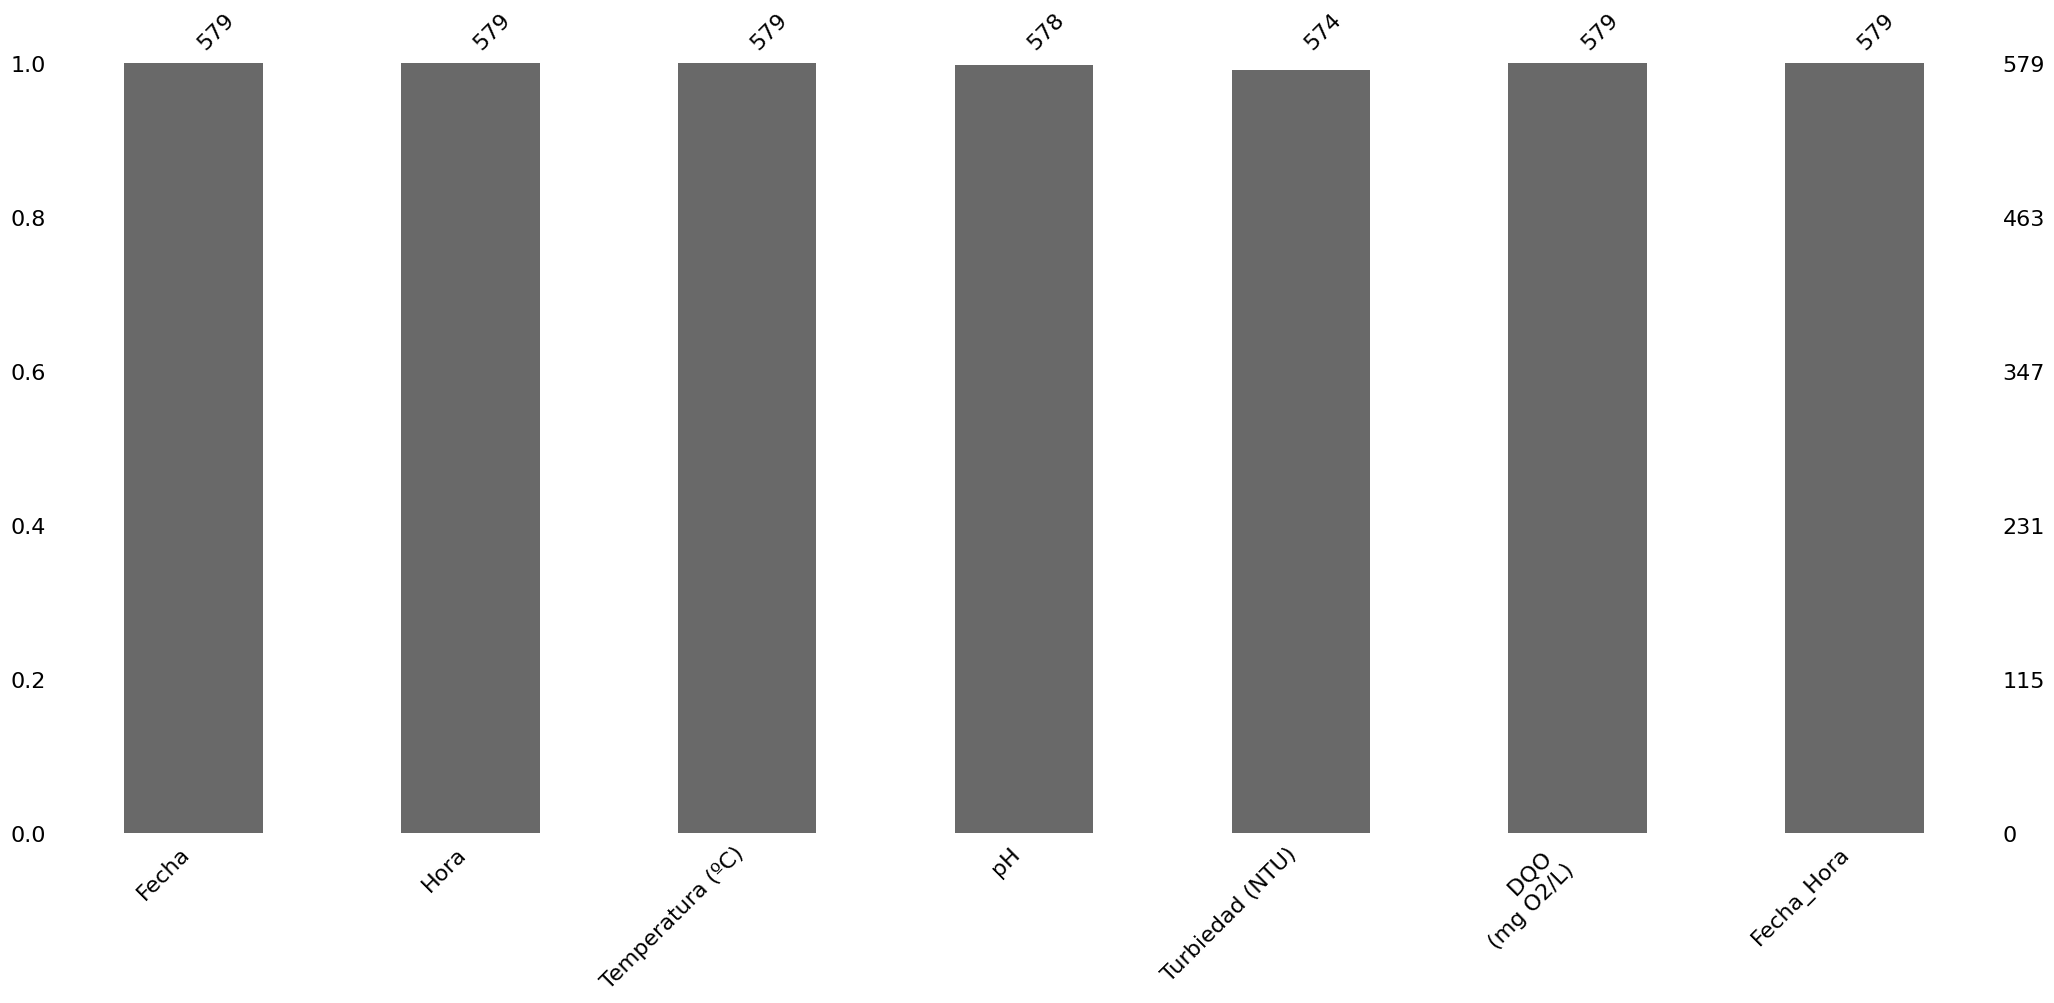

In [408]:
msno.bar(data_lab)

<Axes: >

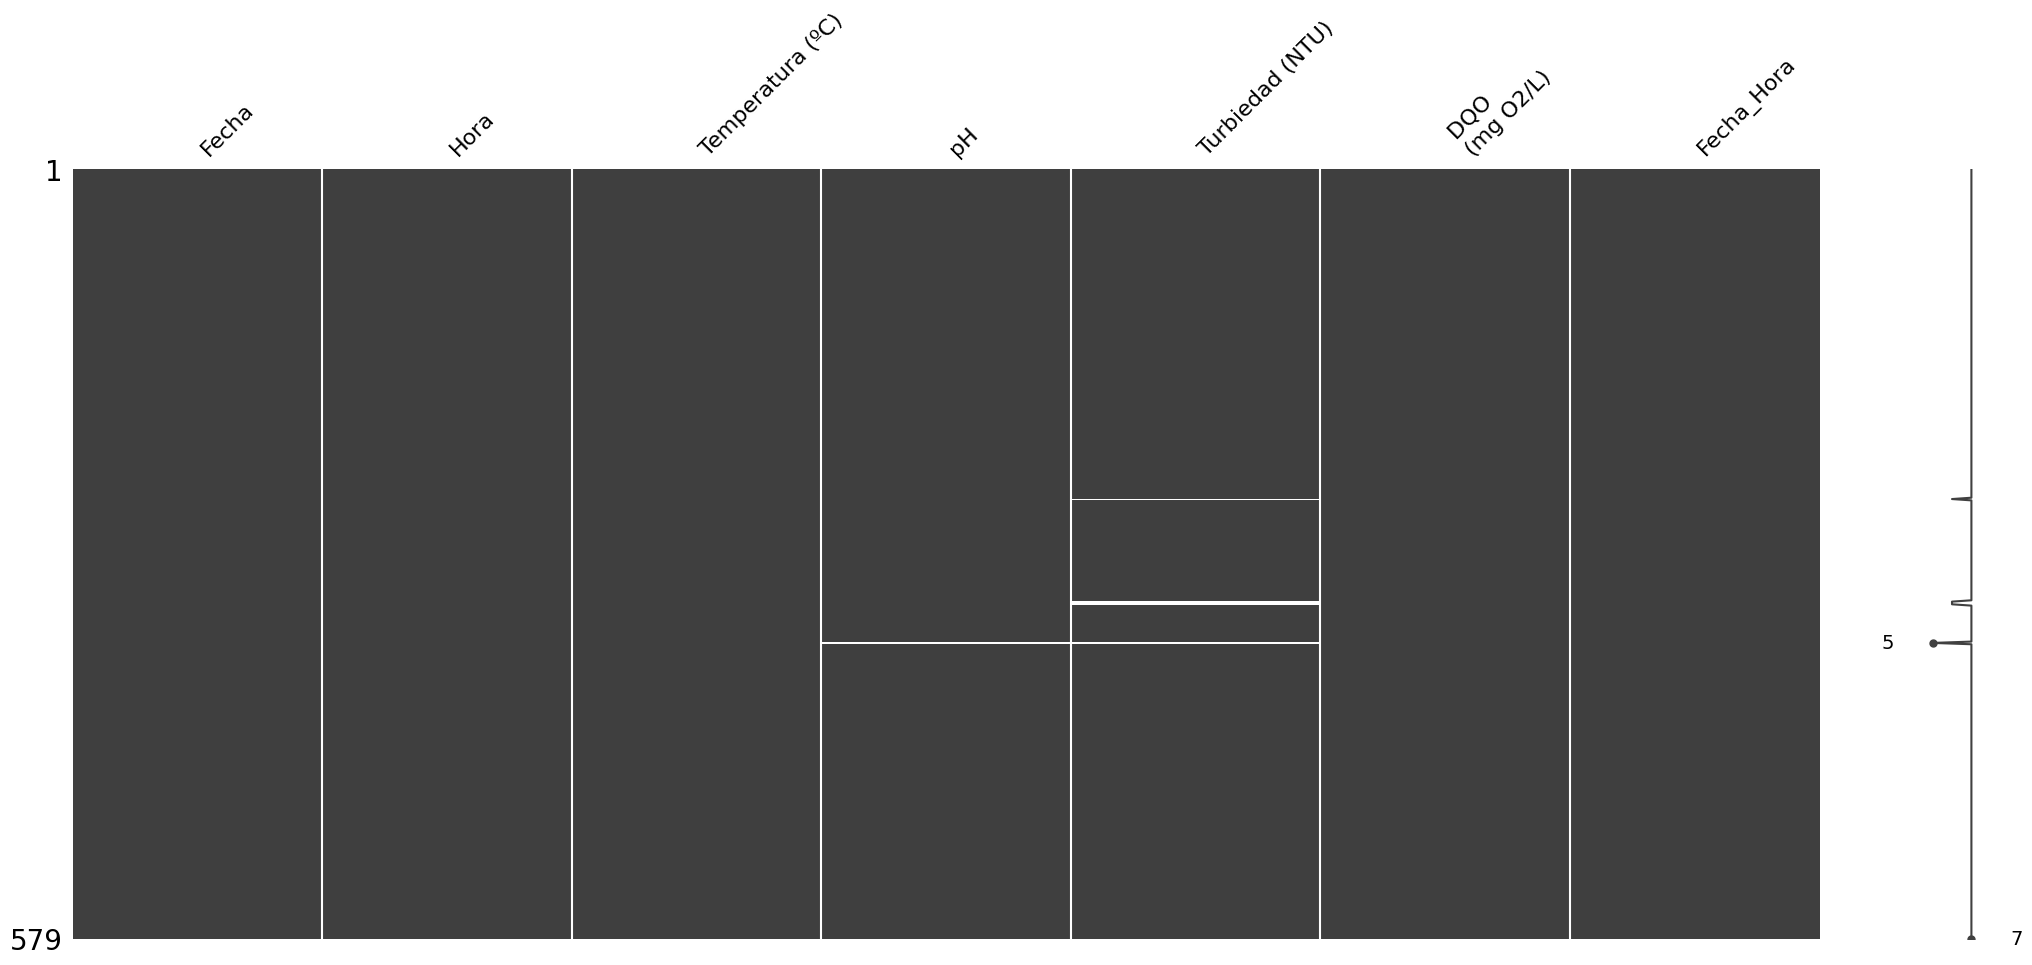

In [409]:
msno.matrix(data_lab)

<Axes: >

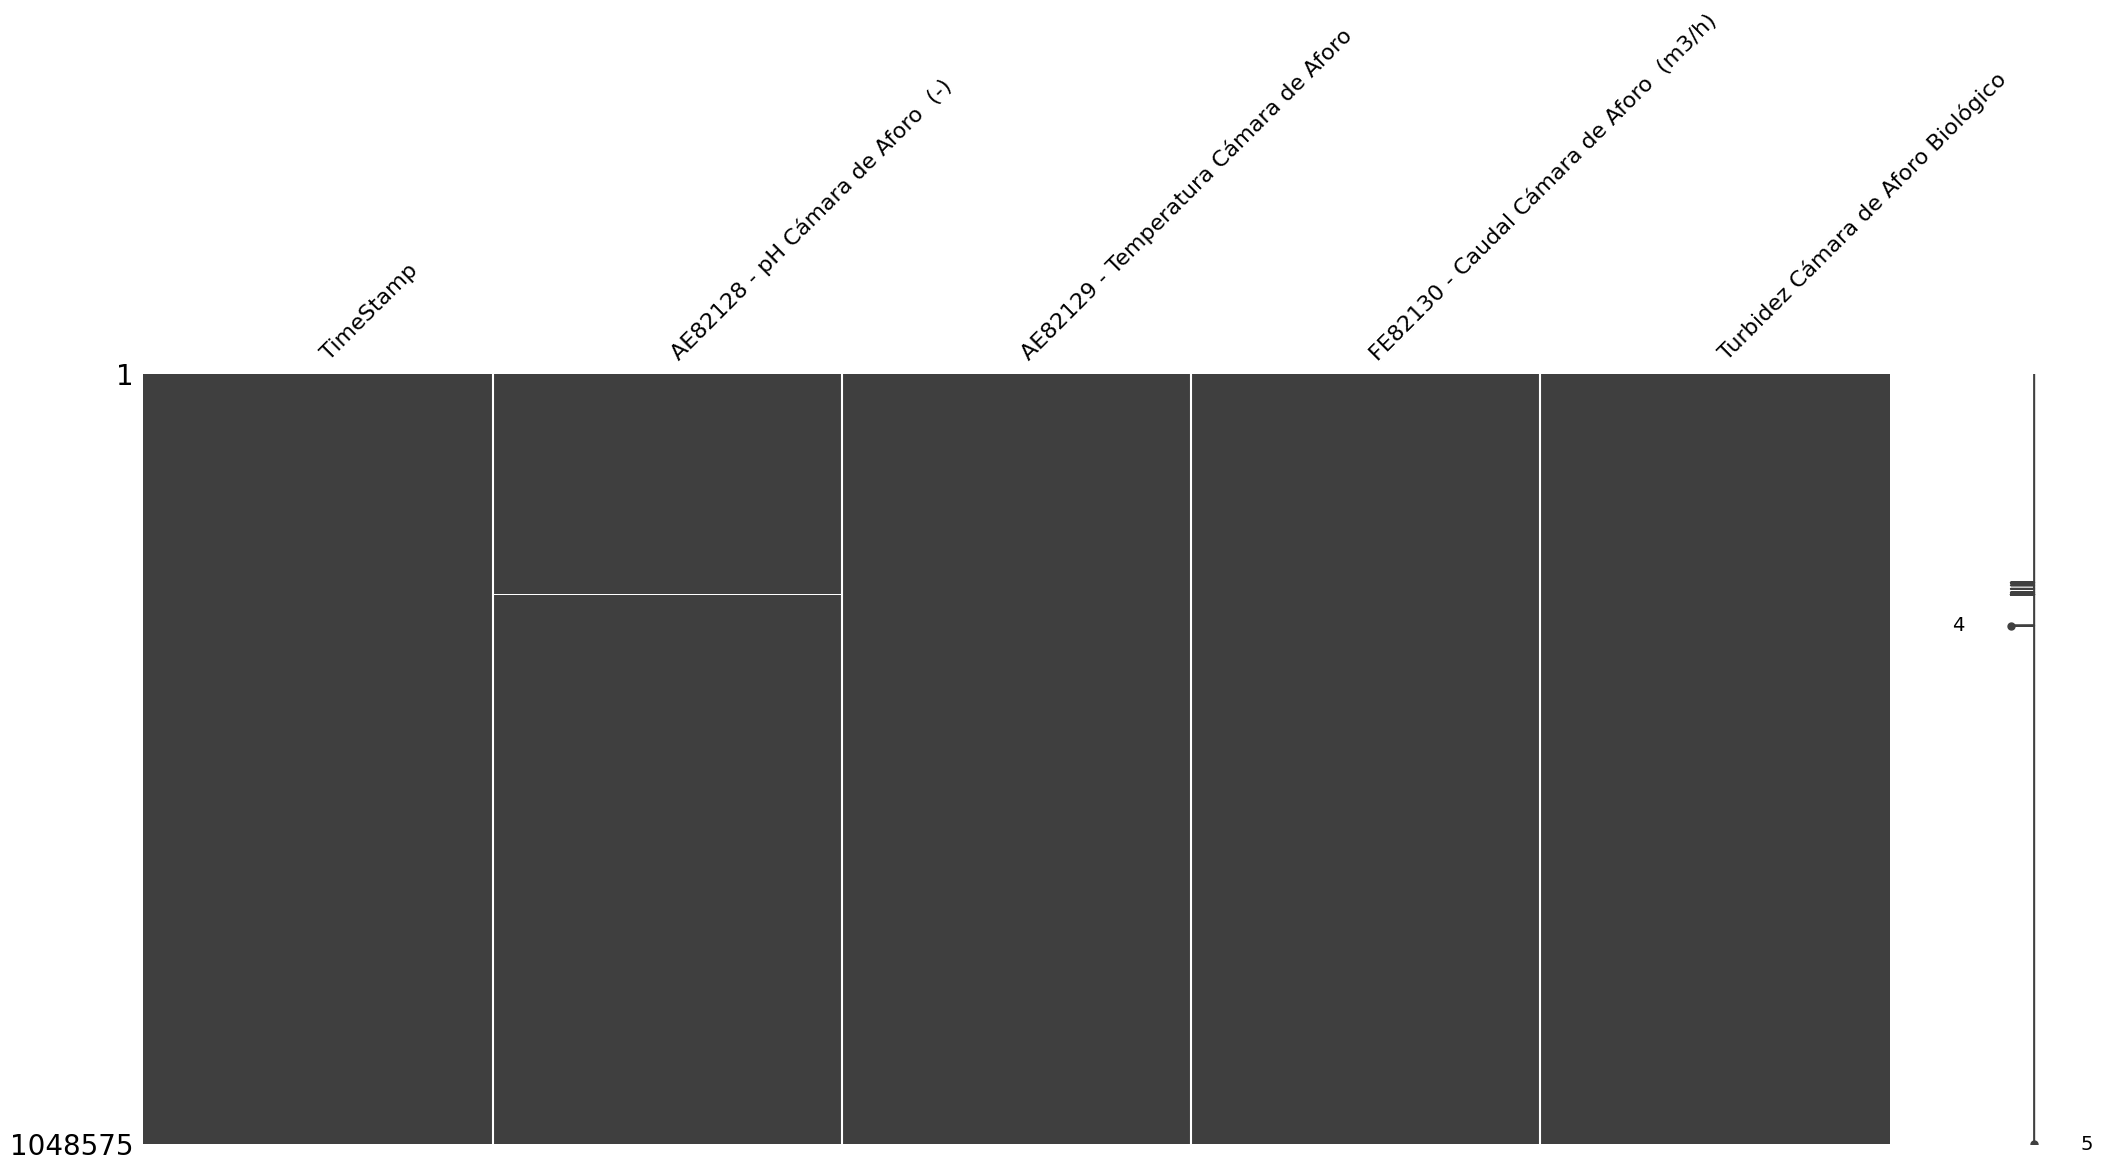

In [410]:
msno.matrix(data_camara)

## Distribuciones

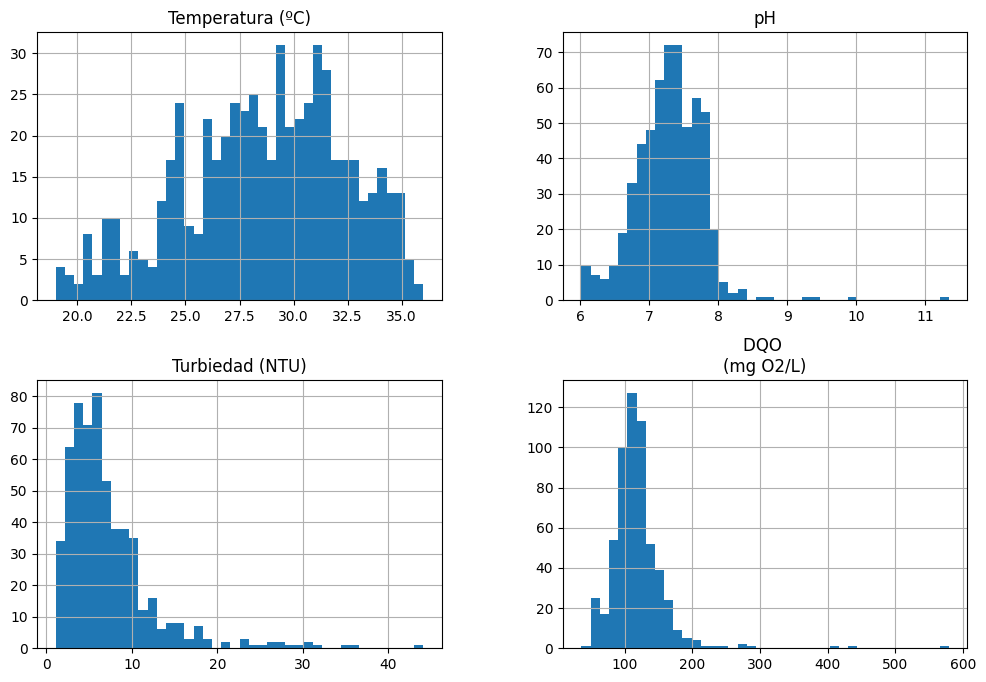

In [411]:
data_lab.select_dtypes(include=['number']).hist(bins=40, figsize=(12, 8))
plt.show()

In [412]:
def boxplots(dataframe, columnas=None, figsize=(12, 8)):
    
    import math

    if columnas is None:
        columnas = dataframe.select_dtypes(include=['number']).columns.tolist()

    num_columnas = len(columnas)
    filas = math.ceil(num_columnas / 2)

    fig, axes = plt.subplots(nrows=filas, ncols=2, figsize=(figsize[0], figsize[1] * filas))

    axes = axes.flatten()

    for ax, col in zip(axes, columnas):
        dataframe.boxplot(column=[col], ax=ax)
        ax.set_title(f"Boxplot - {col}")
        ax.set_ylabel(col)

    for ax in axes[num_columnas:]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

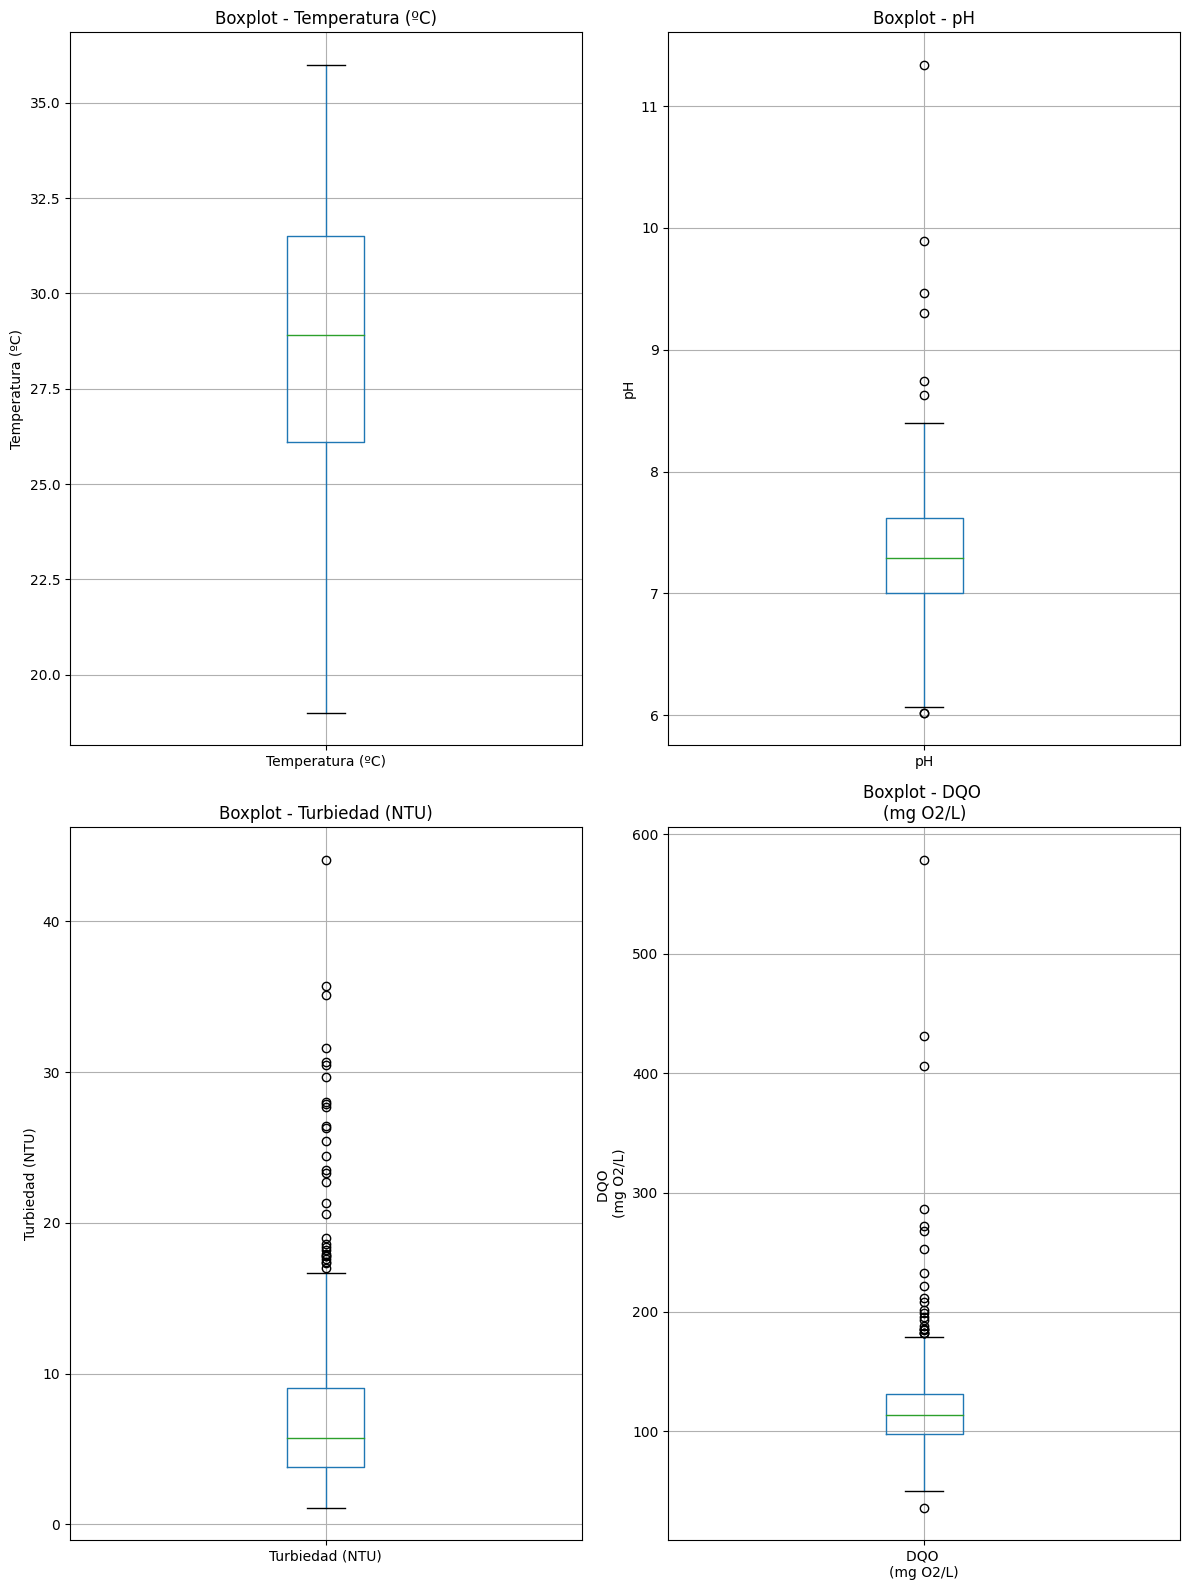

In [413]:
boxplots(data_lab)

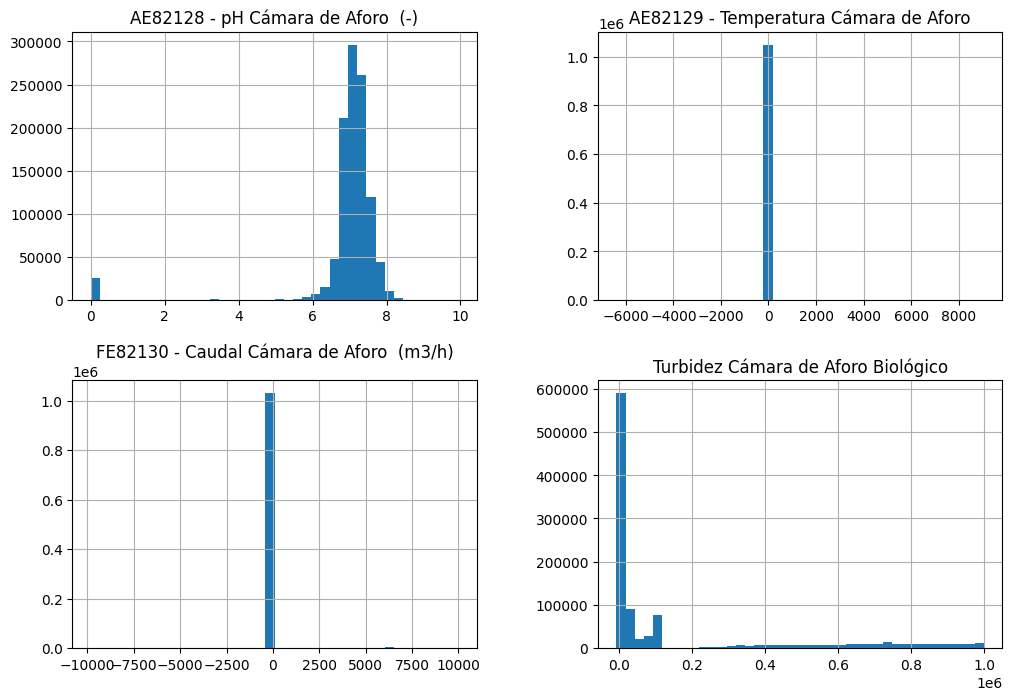

In [414]:
data_camara.select_dtypes(include=['number']).hist(bins=40, figsize=(12, 8))
plt.show()

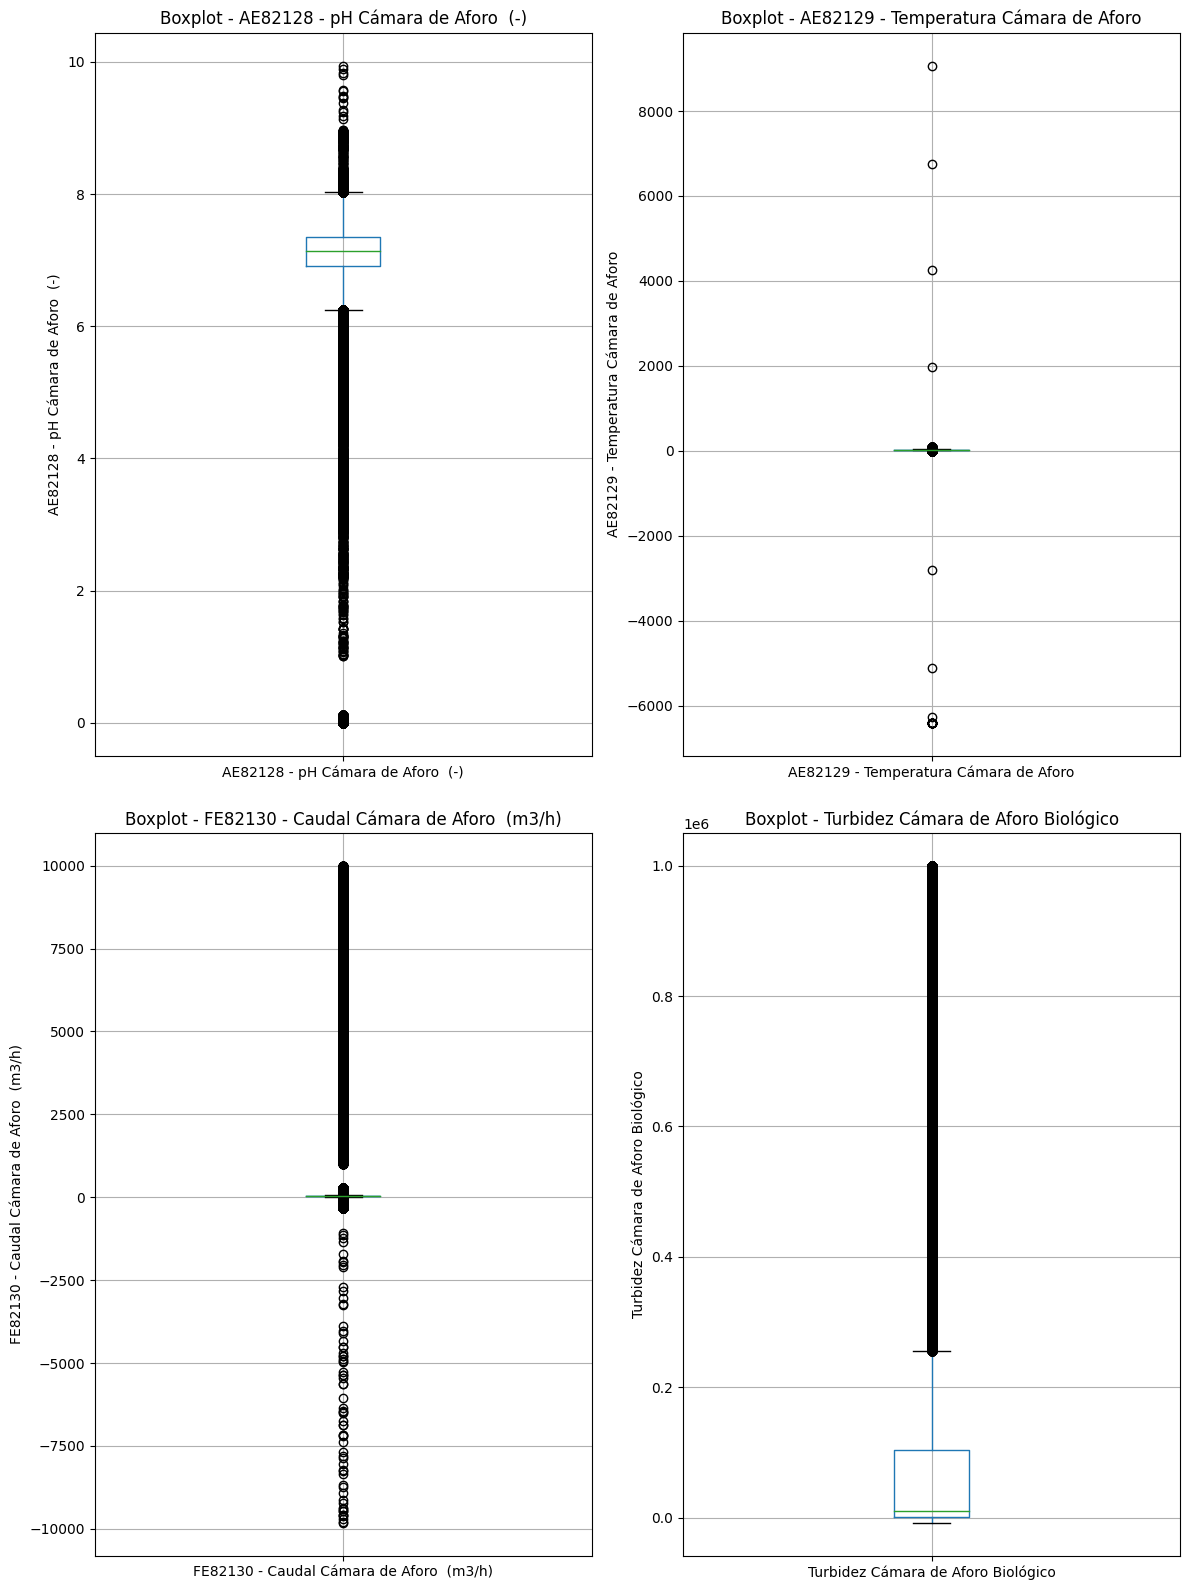

In [415]:
boxplots(data_camara)

## Relaciones en el tiempo

In [416]:
data_lab.select_dtypes(include=['number']).columns

Index(['Temperatura (ºC)', 'pH', 'Turbiedad (NTU)', 'DQO \n(mg O2/L)'], dtype='object')

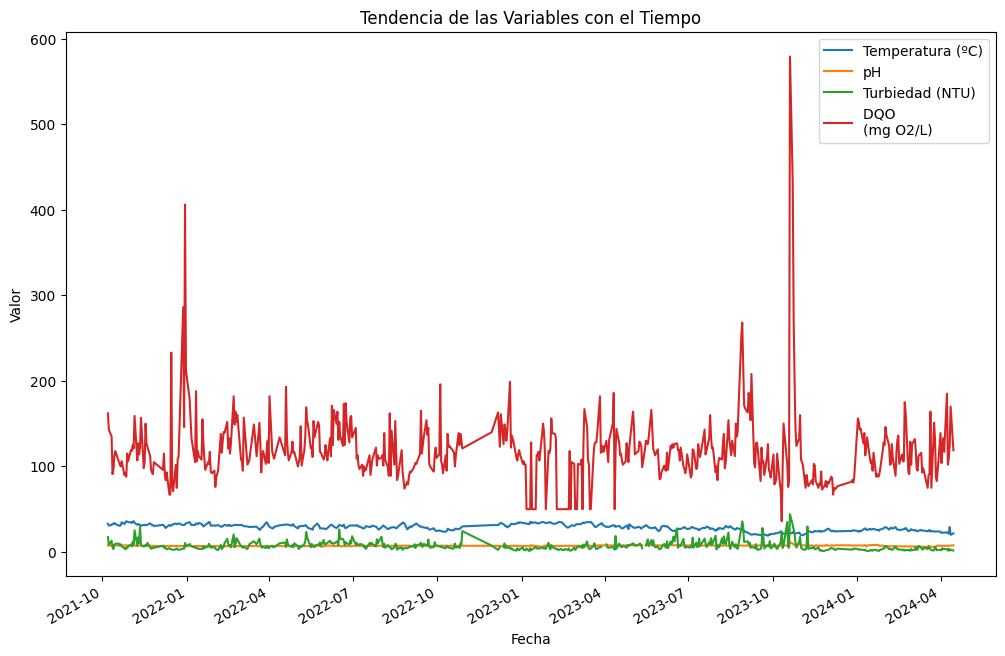

In [417]:
data_lab.set_index('Fecha').select_dtypes(include=['number']).plot(figsize=(12, 8))
plt.title('Tendencia de las Variables con el Tiempo')
plt.ylabel('Valor')
plt.show()


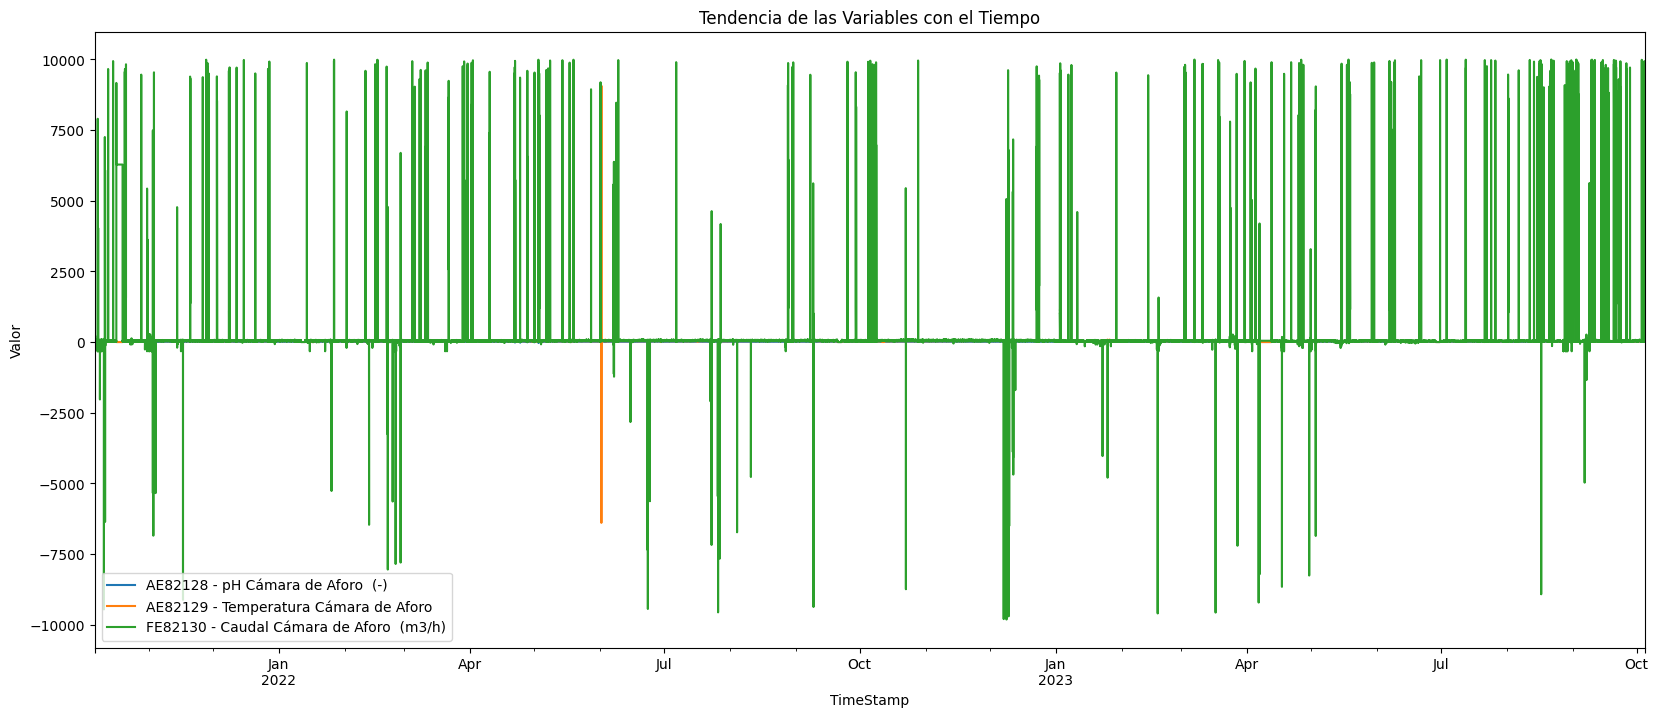

In [418]:
columnas_numericas_sin_turbidez = (
    data_camara.set_index('TimeStamp')
    .select_dtypes(include=['number'])
    .drop(columns=['Turbidez Cámara de Aforo Biológico'], errors='ignore')  # Ignorar errores si no existe la columna
)
columnas_numericas_sin_turbidez.plot(figsize=(20, 8))
plt.title('Tendencia de las Variables con el Tiempo')
plt.ylabel('Valor')
plt.show()

In [419]:
# funcion para nada tomada prestada de otro proyecto mio lol

def plot_categorical_numerical(df, categorical_col, numerical_col, summary_ = False):
    # Calcular la media de la columna numérica por cada categoría
    summary = df.groupby(categorical_col)[numerical_col].mean().reset_index()

    plt.figure(figsize=(12, 6))

    sns.barplot(x=categorical_col, y=numerical_col, data=df, palette= 'Blues')
    media_numerica = df[numerical_col].mean()
    plt.axhline(y=media_numerica, color='red', linestyle='--', label='Media')

    plt.xlabel(categorical_col)
    plt.ylabel(f'Media de {numerical_col}')
    plt.title(f'Relación entre {categorical_col} y {numerical_col}')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

    if summary_ == True:
        return summary

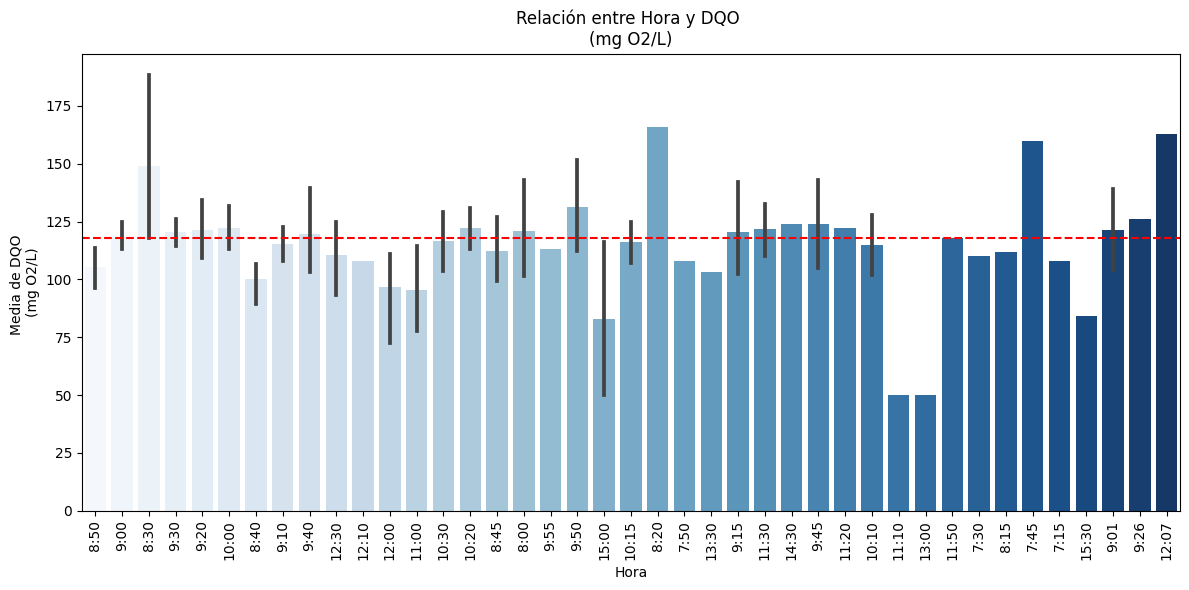

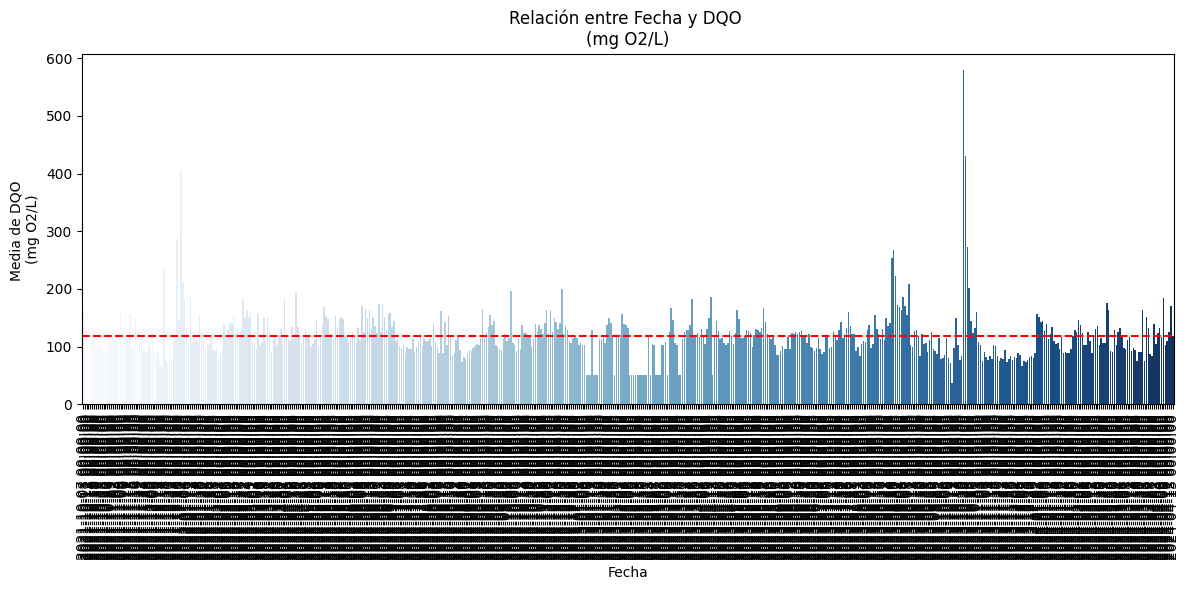

In [420]:
plot_categorical_numerical(data_lab, 'Hora', 'DQO \n(mg O2/L)')
plot_categorical_numerical(data_lab, 'Fecha', 'DQO \n(mg O2/L)')

No se ve un carajo de fecha asique hago mini tratamiento

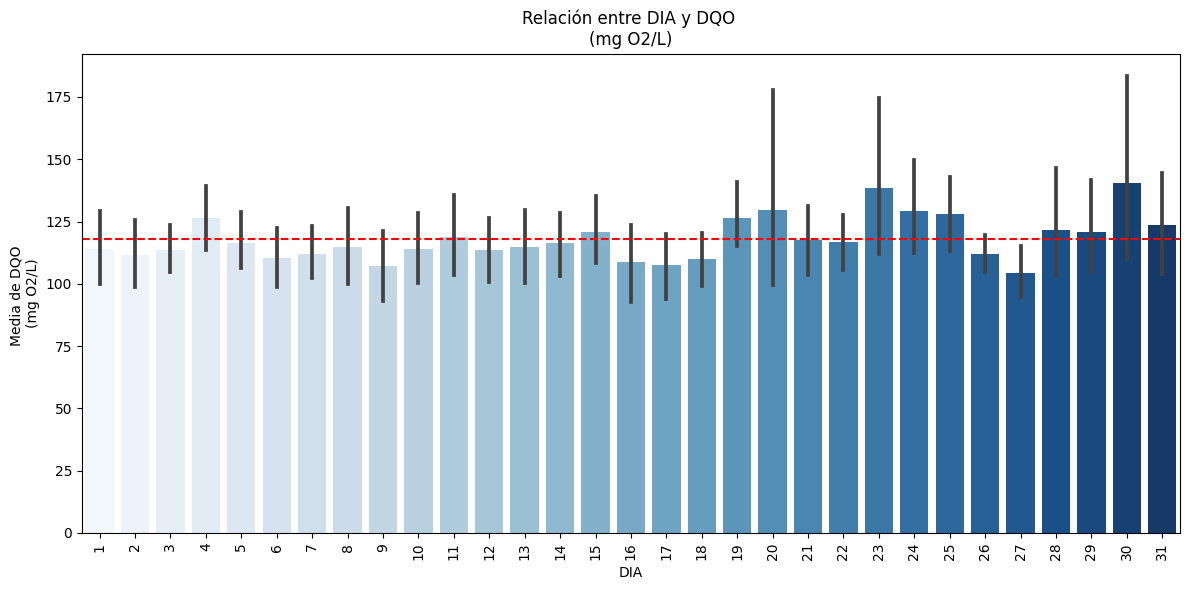

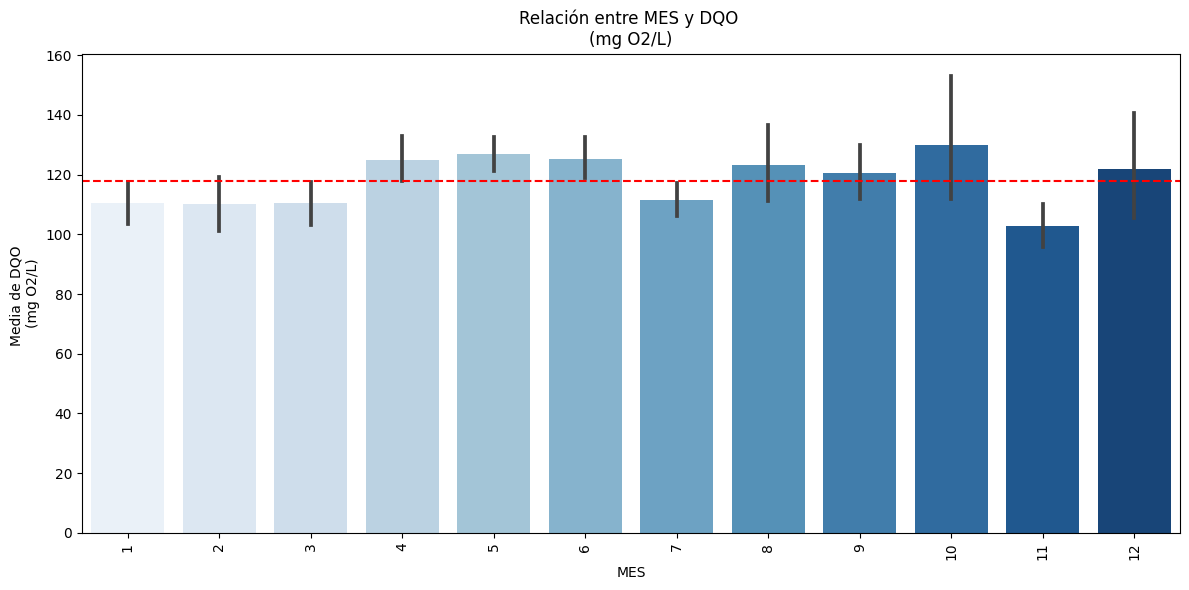

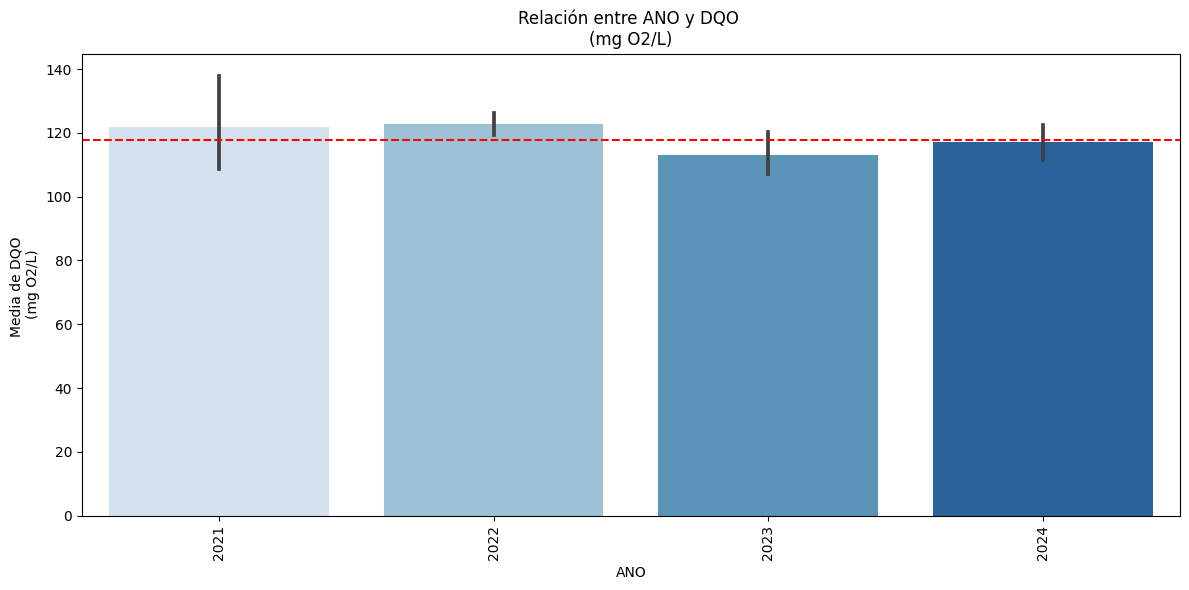

In [421]:
data_lab['DIA'] = data_lab['Fecha'].dt.day
data_lab['MES'] = data_lab['Fecha'].dt.month
data_lab['ANO'] = data_lab['Fecha'].dt.year

plot_categorical_numerical(data_lab, 'DIA', 'DQO \n(mg O2/L)')
plot_categorical_numerical(data_lab, 'MES', 'DQO \n(mg O2/L)')
plot_categorical_numerical(data_lab, 'ANO', 'DQO \n(mg O2/L)')

Mucha consistencia en el tiempo no? o sea no tiene gran seasonality, lo que es bueno creo para una time series prediction

## Correlaciones entre variables

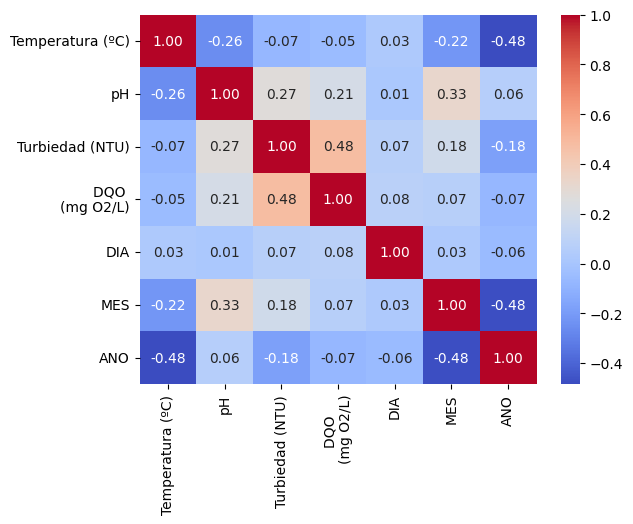

In [422]:
corr_matrix = data_lab.select_dtypes(include=['number']).corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.show()

## Unir los datos

In [423]:
def vincular_dataframes(datos_continuos, datos_diarios, intervalo='1T'):
    """
    Vincula datos continuos y datos diarios en base a un intervalo de tiempo especificado.

    Parámetros:
    - datos_continuos: pd.DataFrame. Contiene los datos medidos continuamente con una columna 'TimeStamp'.
    - datos_diarios: pd.DataFrame. Contiene los datos diarios con una columna 'Fecha_Hora'.
    - intervalo: str. Intervalo de tiempo para redondear (ej. '1T' para minuto, '5T' para 5 minutos).

    Retorna:
    - pd.DataFrame con los datos combinados.
    """
    # Redondear los datos continuos al intervalo especificado
    datos_continuos['TimeStamp_intervalo'] = datos_continuos['TimeStamp'].dt.floor(intervalo)

    # Redondear los datos diarios al intervalo especificado
    datos_diarios['FechaHora_intervalo'] = datos_diarios['Fecha_Hora'].dt.floor(intervalo)

    # Combinar los datos
    datos_combinados = pd.merge(
        datos_diarios,
        datos_continuos,
        left_on='FechaHora_intervalo',
        right_on='TimeStamp_intervalo',
        how='inner'
    )

    return datos_combinados


In [424]:
print(data_lab.dtypes)

Fecha               datetime64[ns]
Hora                        object
Temperatura (ºC)           float64
pH                         float64
Turbiedad (NTU)            float64
DQO \n(mg O2/L)              int64
Fecha_Hora          datetime64[ns]
DIA                          int32
MES                          int32
ANO                          int32
dtype: object


In [425]:
data_1h = vincular_dataframes(data_camara, data_lab, intervalo='1H')
data_1min = vincular_dataframes(data_camara, data_lab, intervalo='1T')

/tmp/ipykernel_30/3714980397.py:14: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  datos_continuos['TimeStamp_intervalo'] = datos_continuos['TimeStamp'].dt.floor(intervalo)
/tmp/ipykernel_30/3714980397.py:17: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  datos_diarios['FechaHora_intervalo'] = datos_diarios['Fecha_Hora'].dt.floor(intervalo)
/tmp/ipykernel_30/3714980397.py:14: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  datos_continuos['TimeStamp_intervalo'] = datos_continuos['TimeStamp'].dt.floor(intervalo)
/tmp/ipykernel_30/3714980397.py:17: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  datos_diarios['FechaHora_intervalo'] = datos_diarios['Fecha_Hora'].dt.floor(intervalo)


In [426]:
unique_des_count = data_1min.groupby('TimeStamp')['TimeStamp_intervalo'].nunique()
is_determined = unique_des_count.eq(1).all()

print("¿TimeStamp determina TimeStamp_intervalo?", is_determined)

unique_des_count = data_1min.groupby('Fecha_Hora')['FechaHora_intervalo'].nunique()
is_determined = unique_des_count.eq(1).all()

print("¿Fecha_Hora determina FechaHora_intervalo?", is_determined)

unique_des_count = data_1min.groupby('Fecha_Hora')['TimeStamp'].nunique()
is_determined = unique_des_count.eq(1).all()

print("¿Fecha_Hora determina TimeStamp?", is_determined)

¿TimeStamp determina TimeStamp_intervalo? True
¿Fecha_Hora determina FechaHora_intervalo? True
¿Fecha_Hora determina TimeStamp? True


In [427]:
data_1min = data_1min.drop(columns = ['TimeStamp_intervalo','FechaHora_intervalo', 'Fecha_Hora', 'Fecha', 'Hora', 'DIA', 'MES', 'ANO' ])
data_1min.head()

,Temperatura (ºC),pH,Turbiedad (NTU),DQO \n(mg O2/L),TimeStamp,AE82128 - pH Cámara de Aforo (-),AE82129 - Temperatura Cámara de Aforo,FE82130 - Caudal Cámara de Aforo (m3/h),Turbidez Cámara de Aforo Biológico
0,33.0,7.65,17.40,162,2021-10-07 08:50:00,7.67000,33.00000,41.81750,2871.333
1,30.9,7.72,8.23,143,2021-10-08 09:00:00,7.72333,31.10000,30.93500,1795.667
2,31.7,7.50,13.19,135,2021-10-11 08:30:00,7.44000,31.45000,38.57667,20799.167
3,32.9,7.50,5.37,91,2021-10-12 09:00:00,7.49208,32.55000,33.60000,1525.667
4,32.8,7.70,3.52,96,2021-10-13 09:30:00,7.68000,32.67778,41.93000,2244.333


In [428]:
print(data_1min.isna().sum())

correlaciones = data_1min.corr()
print(correlaciones['DQO \n(mg O2/L)'].sort_values(ascending=False))

Temperatura (ºC)                            0
pH                                          1
Turbiedad (NTU)                             5
DQO \n(mg O2/L)                             0
TimeStamp                                   0
AE82128 - pH Cámara de Aforo  (-)           0
AE82129 - Temperatura Cámara de Aforo       0
FE82130 - Caudal Cámara de Aforo  (m3/h)    0
Turbidez Cámara de Aforo Biológico          0
dtype: int64
DQO \n(mg O2/L)                             1.000000
Turbiedad (NTU)                             0.402378
AE82128 - pH Cámara de Aforo  (-)          -0.008709
FE82130 - Caudal Cámara de Aforo  (m3/h)   -0.031260
AE82129 - Temperatura Cámara de Aforo      -0.048493
TimeStamp                                  -0.055921
pH                                         -0.059915
Temperatura (ºC)                           -0.079733
Turbidez Cámara de Aforo Biológico         -0.178207
Name: DQO \n(mg O2/L), dtype: float64


In [429]:
print(data_1min.shape)
data_1min = data_1min.dropna()
print(data_1min.shape)

(457, 9)
(452, 9)


# Estrategia modelo

1. Exploración y Relación de Datos
Validar la relación temporal: Asegúrate de que los datos diarios y los continuos se puedan alinear correctamente a través de Timestamp y las columnas de Fecha y Hora. Considera convertir todo a un formato de fecha y hora estándar (datetime).
Explorar correlaciones iniciales: Calcula las correlaciones entre las variables continuas (pH, Temperatura, Caudal, Turbidez) y la DQO diaria. Esto te dará una idea de cuáles son más relevantes.
2. Preprocesamiento
Imputación de faltantes en datos diarios: Aunque mencionaste que no hay faltantes en los datos continuos, asegúrate de que no haya huecos en la columna DQO de los datos diarios. Si los hay, considera imputarlos basándote en valores cercanos.
Resampleo de datos continuos:
Agrupa los datos continuos a frecuencias específicas (por minuto, cada 5 minutos, o incluso promedios diarios) para alinearlos con los datos diarios de DQO.
Prueba estadísticas como promedio, mediana, máximos, mínimos y desviaciones estándar dentro de las ventanas temporales.
3. Ingeniería de Características
Derivar características adicionales:
Crear diferencias o tasas de cambio en variables como pH y Turbidez.
Incluir tendencias (mediante rolling windows) para variables continuas.
Variables categóricas como días laborables/fines de semana, estacionalidad, etc.
Lagging de variables:
Considera introducir retardos (lags) en las variables continuas para reflejar relaciones con la DQO diaria. Por ejemplo, los valores de pH o Turbidez unas horas antes podrían afectar la DQO.
4. Modelos
Series Temporales:

- SARIMA: Útil si la DQO muestra una fuerte estacionalidad y patrones consistentes.
- Prophet: Puede manejar irregularidades y estacionalidad no lineal.
- Machine Learning:
    1. Regresión lineal: Comienza con algo simple para establecer un punto de comparación.
    2. Random Forest y XGBoost: Ideal para capturar relaciones no lineales.
    3. Redes neuronales: Considera modelos como LSTM o GRU si el componente temporal es muy fuerte.
5. Evaluación y Optimización
Evalúa los modelos usando métricas específicas:
RMSE para la precisión general.
Porcentaje de predicciones dentro del ±10% para cumplir con los requisitos del desafío.
Compara la precisión de predicciones minuto a minuto y cada 5 minutos para determinar cuál estrategia es más efectiva.
6. Iteración
Ajusta los modelos basándote en los resultados iniciales.
Introduce más variables derivadas o ajusta las ventanas de resampleo para mejorar la calidad de las predicciones.
Si tienes datos específicos o resultados iniciales, puedo ayudarte a ajustar esta estrategia o implementar directamente algún modelo o análisis.

In [430]:
# table para guardar los resultados
experiment_records = pd.DataFrame(
    columns = ['Experiment', 'Model', 'Columns used', 'RMSE', '+-10% %']
    )
experiment_records

,Experiment,Model,Columns used,RMSE,+-10% %


## Series de tiempo

### Sarima

In [431]:
serie_dqo = data_1min.set_index('TimeStamp')['DQO \n(mg O2/L)']

# train y test
train_size = int(len(serie_dqo) * 0.8)
train, test = serie_dqo[:train_size], serie_dqo[train_size:]

modelo_sarima = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 24))  # Ajusta los hiperparámetros
resultado_sarima = modelo_sarima.fit()

predicciones = resultado_sarima.forecast(steps=len(test))

rmse = mean_squared_error(test, predicciones, squared=False)
mse = mean_squared_error(test, predicciones)

experimento = ['Exp 1', 'Sarima', 'DQO y TimeStamp', rmse,'' ]
experiment_records.loc[len(experiment_records)] = experimento

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.75576D+00    |proj g|=  7.88905D-02

At iterate    5    f=  4.71783D+00    |proj g|=  1.13624D-02

At iterate   10    f=  4.69053D+00    |proj g|=  6.54866D-02

At iterate   15    f=  4.64682D+00    |proj g|=  2.52405D-03

At iterate   20    f=  4.64561D+00    |proj g|=  2.12138D-02

At iterate   25    f=  4.64473D+00    |proj g|=  5.68277D-04

At iterate   30    f=  4.64424D+00    |proj g|=  7.57505D-03

At iterate   35    f=  4.64407D+00    |proj g|=  6.28944D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [432]:
serie_dqo = data_1h.set_index('TimeStamp')['DQO \n(mg O2/L)']

# train y test
train_size = int(len(serie_dqo) * 0.8)
train, test = serie_dqo[:train_size], serie_dqo[train_size:]

modelo_sarima = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 24))  # Ajusta los hiperparámetros
resultado_sarima = modelo_sarima.fit()

predicciones = resultado_sarima.forecast(steps=len(test))

rmse = mean_squared_error(test, predicciones, squared=False)
mse = mean_squared_error(test, predicciones)

experimento = ['Exp 2 data 1 h', 'Sarima', 'DQO y TimeStamp', rmse,'' ]
experiment_records.loc[len(experiment_records)] = experimento

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.16643D+00    |proj g|=  1.05200D-01

At iterate    5    f=  3.01104D+00    |proj g|=  7.73444D-03

At iterate   10    f=  3.00401D+00    |proj g|=  2.00106D-03

At iterate   15    f=  3.00259D+00    |proj g|=  9.61799D-04

At iterate   20    f=  3.00252D+00    |proj g|=  2.58226D-03

At iterate   25    f=  3.00250D+00    |proj g|=  3.36089D-04

At iterate   30    f=  3.00250D+00    |proj g|=  3.06813D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


### ARMA

In [433]:
serie_dqo = data_1min.set_index('TimeStamp')['DQO \n(mg O2/L)']

train_size = int(len(serie_dqo) * 0.8)
train, test = serie_dqo[:train_size], serie_dqo[train_size:]


order = (2, 2, 2)  # params (p, d, q) ### podriamos probar con cambiarlos capaz
ARIMAmodel = ARIMA(train, order=order)
ARIMAmodel = ARIMAmodel.fit()

y_pred = ARIMAmodel.get_forecast(len(test))
y_pred_df = y_pred.conf_int(alpha=0.05)  # intervalo de confianza 95%
y_pred_df["Predictions"] = ARIMAmodel.predict(start=y_pred_df.index[0], end=y_pred_df.index[-1])
y_pred_df.index = test.index

# Extraer predicciones finales
y_pred_out = y_pred_df["Predictions"]

rmse = np.sqrt(mean_squared_error(test.values, y_pred_out))
print("RMSE:", rmse)

experimento = [f'Exp {len(experiment_records)} data 1min', 'Arma', 'DQO y TimeStamp', rmse,'' ]

experiment_records.loc[len(experiment_records)] = experimento

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


RMSE: 36.47758312669961


/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


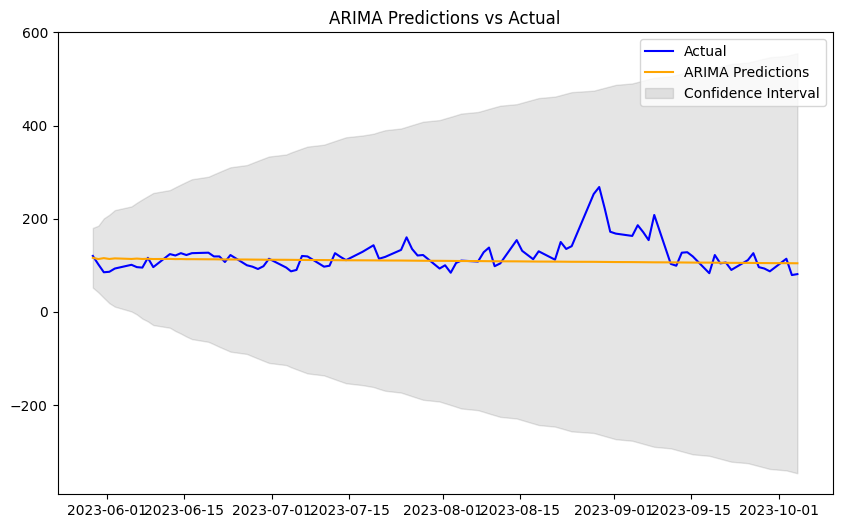

In [434]:
plt.figure(figsize=(10, 6))
plt.plot(test, color='blue', label='Actual')
plt.plot(y_pred_out, color='orange', label='ARIMA Predictions')
plt.fill_between(
    y_pred_df.index,
    y_pred_df.iloc[:, 0],  # Lower bound of confidence interval
    y_pred_df.iloc[:, 1],  # Upper bound of confidence interval
    color='k',
    alpha=0.1,
    label='Confidence Interval'
)
plt.legend()
plt.title('ARIMA Predictions vs Actual')
plt.show()

### Prophet

In [435]:
# Preparar datos para Prophet
data_prophet = data_1min[['TimeStamp', 'DQO \n(mg O2/L)']].rename(
    columns={'TimeStamp': 'ds', 'DQO \n(mg O2/L)': 'y'}
)

train_size = int(len(data_prophet) * 0.8)
train, test = data_prophet.iloc[:train_size], data_prophet.iloc[train_size:]

modelo_prophet = Prophet()
modelo_prophet.fit(train)

future = modelo_prophet.make_future_dataframe(periods=len(test), freq='5T')
forecast = modelo_prophet.predict(future)

predicciones = forecast[['ds', 'yhat']].iloc[-len(test):]

rmse = mean_squared_error(test['y'], predicciones['yhat'], squared=False)


experimento = [f'Exp {len(experiment_records)}', 'Prophet', 'DQO y TimeStamp', rmse,'' ]
experiment_records.loc[len(experiment_records)] = experimento

20:57:22 - cmdstanpy - INFO - Chain [1] start processing
20:57:22 - cmdstanpy - INFO - Chain [1] done processing
/opt/conda/lib/python3.10/site-packages/prophet/forecaster.py:1854: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  dates = pd.date_range(


### Neural Prophet
Buscar y correr

In [436]:
experiment_records

,Experiment,Model,Columns used,RMSE,+-10% %
0,Exp 1,Sarima,DQO y TimeStamp,33.481561,
1,Exp 2 data 1 h,Sarima,DQO y TimeStamp,37.347139,
2,Exp 2 data 1min,Arma,DQO y TimeStamp,36.477583,
3,Exp 3,Prophet,DQO y TimeStamp,46.266751,


### Deep AR
Hacer andar lol no entendi como hacer como que la data entra de una forma particular

In [437]:
#!pip install gluonts

In [438]:
import pandas as pd
from gluonts.dataset.common import ListDataset

# Prepare the time series dataset
def prepare_deepar_data(data):
    """
    Prepare data for DeepAR, splitting into training and test datasets.
    """
    # Ensure the dataset is sorted by time
    data = data.sort_values(by='TimeStamp')

    # Handle missing values
    data['DQO \n(mg O2/L)'] = data['DQO \n(mg O2/L)'].fillna(method='ffill')

    # Split data into training and testing
    train_size = int(len(data) * 0.8)
    train, test = data.iloc[:train_size], data.iloc[train_size:]

    # Convert training data to ListDataset format
    train_data = ListDataset(
        [{"start": row['TimeStamp'], "target": [row['DQO \n(mg O2/L)']]} for _, row in train.iterrows()],
        freq="5min"
    )

    # Convert test data to ListDataset format
    test_data = ListDataset(
        [{"start": row['TimeStamp'], "target": [row['DQO \n(mg O2/L)']]} for _, row in test.iterrows()],
        freq="5min"
    )

    return train_data, test_data

# Prepare the data
train_data, test_data = prepare_deepar_data(data_1min)


from gluonts.model.deepar import DeepAREstimator
from gluonts.trainer import Trainer

# Define the DeepAR estimator
estimator = DeepAREstimator(
    freq="5min",
    prediction_length=12,  # Forecast 1 hour ahead (12 intervals of 5 minutes)
    trainer=Trainer(epochs=20, learning_rate=1e-3)
)

# Train the model
from gluonts.model.predictor import Predictor

predictor = estimator.train(training_data=train_data)


# Generate predictions on the test set
from gluonts.evaluation import Evaluator
from gluonts.evaluation.backtest import make_evaluation_predictions

forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_data,
    predictor=predictor,
    num_samples=100  # Number of Monte Carlo samples
)

# Convert predictions to DataFrame for inspection
forecasts = list(forecast_it)
tss = list(ts_it)

# Example: Plot a single forecast
import matplotlib.pyplot as plt

for i in range(3):  # Plot first 3 forecasts
    tss[i].plot()
    forecasts[i].plot()
    plt.show()


/tmp/ipykernel_30/2915389764.py:13: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['DQO \n(mg O2/L)'] = data['DQO \n(mg O2/L)'].fillna(method='ffill')


ModuleNotFoundError: No module named 'gluonts.model.deepar'

## ML approach

Segun el coso de ancap, solo podemos usar data continua para predecir el dqo

In [439]:
columnas_continuas = list(data_camara.columns)[:-1] # sin el timestamp que inventabamos
print(columnas_continuas)

['TimeStamp', 'AE82128 - pH Cámara de Aforo  (-)', 'AE82129 - Temperatura Cámara de Aforo', 'FE82130 - Caudal Cámara de Aforo  (m3/h)', 'Turbidez Cámara de Aforo Biológico']


In [440]:
data_ml = data_1min.copy()
data_ml = data_ml[columnas_continuas + ['DQO \n(mg O2/L)']]

### Random Forest Regressor

In [441]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

# crear características basadas en series temporales
data_ml['DQO_lag_1'] = data_ml['DQO \n(mg O2/L)'].shift(1)
data_ml['DQO_rolling_mean'] = data_ml['DQO \n(mg O2/L)'].rolling(window=3).mean()

data_ml = data_ml.dropna()

X = data_ml[['AE82128 - pH Cámara de Aforo  (-)', 'AE82129 - Temperatura Cámara de Aforo', 'FE82130 - Caudal Cámara de Aforo  (m3/h)', 'Turbidez Cámara de Aforo Biológico','DQO_lag_1', 'DQO_rolling_mean']]
y = data_ml['DQO \n(mg O2/L)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

model = RandomForestRegressor(random_state=42, n_estimators=100)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# ±10%
margen_10 = 0.1 * y_test
dentro_del_rango = ((y_test - margen_10 <= y_pred) & (y_pred <= y_test + margen_10)).mean() * 100

experimento = [f'Exp {len(experiment_records)}', 'ML RandomForestRegressor', ['AE82128 - pH Cámara de Aforo  (-)', 'AE82129 - Temperatura Cámara de Aforo', 'FE82130 - Caudal Cámara de Aforo  (m3/h)', 'Turbidez Cámara de Aforo Biológico','DQO_lag_1', 'DQO_rolling_mean'], rmse, dentro_del_rango]
experiment_records.loc[len(experiment_records)] = experimento


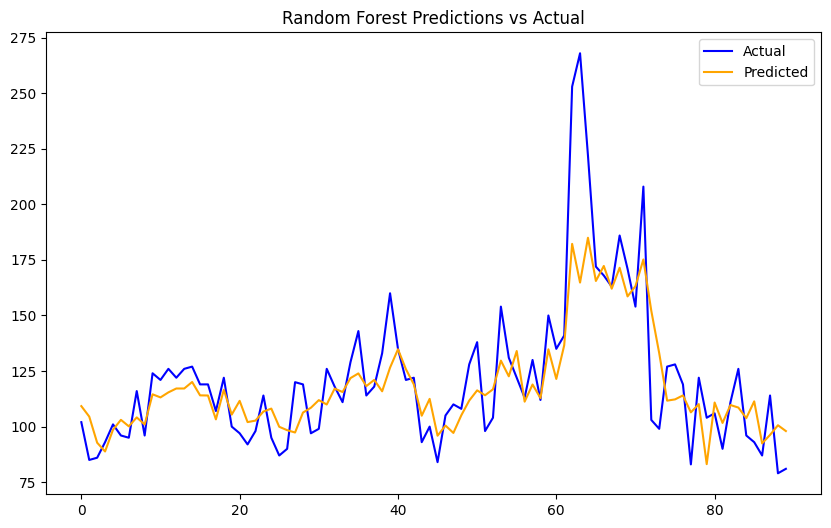

In [442]:
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual', color='blue')
plt.plot(y_pred, label='Predicted', color='orange')
plt.legend()
plt.title('Random Forest Predictions vs Actual')
plt.show()

### XBG Regressor

In [443]:
from xgboost import XGBRegressor

model = XGBRegressor(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# ±10%
margen_10 = 0.1 * y_test
dentro_del_rango = ((y_test - margen_10 <= y_pred) & (y_pred <= y_test + margen_10)).mean() * 100

experimento = [f'Exp {len(experiment_records)}', 'ML XGBRegressor', ['AE82128 - pH Cámara de Aforo  (-)', 'AE82129 - Temperatura Cámara de Aforo', 'FE82130 - Caudal Cámara de Aforo  (m3/h)', 'Turbidez Cámara de Aforo Biológico','DQO_lag_1', 'DQO_rolling_mean'], rmse, dentro_del_rango]
experiment_records.loc[len(experiment_records)] = experimento

### CatBoostRegressor

In [444]:
from catboost import CatBoostRegressor

cat_model = CatBoostRegressor(iterations=500, learning_rate=0.1, depth=6, random_state=42, verbose=0)
cat_model.fit(X_train, y_train)

y_pred = cat_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# ±10%
margen_10 = 0.1 * y_test
dentro_del_rango = ((y_test - margen_10 <= y_pred) & (y_pred <= y_test + margen_10)).mean() * 100

experimento = [f'Exp {len(experiment_records)}', 'ML CatBoostRegressor', ['AE82128 - pH Cámara de Aforo  (-)', 'AE82129 - Temperatura Cámara de Aforo', 'FE82130 - Caudal Cámara de Aforo  (m3/h)', 'Turbidez Cámara de Aforo Biológico','DQO_lag_1', 'DQO_rolling_mean'], rmse, dentro_del_rango]
experiment_records.loc[len(experiment_records)] = experimento

### Gradient Boost Regressor

In [445]:
from sklearn.ensemble import GradientBoostingRegressor

gbr_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gbr_model.fit(X_train, y_train)

y_pred = gbr_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# ±10%
margen_10 = 0.1 * y_test
dentro_del_rango = ((y_test - margen_10 <= y_pred) & (y_pred <= y_test + margen_10)).mean() * 100

experimento = [f'Exp {len(experiment_records)}', 'ML GradientBoostingRegressor', ['AE82128 - pH Cámara de Aforo  (-)', 'AE82129 - Temperatura Cámara de Aforo', 'FE82130 - Caudal Cámara de Aforo  (m3/h)', 'Turbidez Cámara de Aforo Biológico','DQO_lag_1', 'DQO_rolling_mean'], rmse, dentro_del_rango]
experiment_records.loc[len(experiment_records)] = experimento

### LightGBM

In [446]:
from lightgbm import LGBMRegressor

lgb_model = LGBMRegressor(n_estimators=500, learning_rate=0.05, max_depth=6, random_state=42)
lgb_model.fit(X_train, y_train)

y_pred = lgb_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# ±10%
margen_10 = 0.1 * y_test
dentro_del_rango = ((y_test - margen_10 <= y_pred) & (y_pred <= y_test + margen_10)).mean() * 100

experimento = [f'Exp {len(experiment_records)}', 'ML LGBMRegressor', ['AE82128 - pH Cámara de Aforo  (-)', 'AE82129 - Temperatura Cámara de Aforo', 'FE82130 - Caudal Cámara de Aforo  (m3/h)', 'Turbidez Cámara de Aforo Biológico','DQO_lag_1', 'DQO_rolling_mean'], rmse, dentro_del_rango]
experiment_records.loc[len(experiment_records)] = experimento

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000049 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 612
[LightGBM] [Info] Number of data points in the train set: 360, number of used features: 6
[LightGBM] [Info] Start training from score 117.633333
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

### MLPRegressor

In [447]:
from sklearn.neural_network import MLPRegressor

mlp_model = MLPRegressor(hidden_layer_sizes=(64, 64), max_iter=500, random_state=42)
mlp_model.fit(X_train, y_train)

y_pred = mlp_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# ±10%
margen_10 = 0.1 * y_test
dentro_del_rango = ((y_test - margen_10 <= y_pred) & (y_pred <= y_test + margen_10)).mean() * 100

experimento = [f'Exp {len(experiment_records)}', 'ML MLPRegressor', ['AE82128 - pH Cámara de Aforo  (-)', 'AE82129 - Temperatura Cámara de Aforo', 'FE82130 - Caudal Cámara de Aforo  (m3/h)', 'Turbidez Cámara de Aforo Biológico','DQO_lag_1', 'DQO_rolling_mean'], rmse, dentro_del_rango]
experiment_records.loc[len(experiment_records)] = experimento

### ElasticNet

In [448]:
from sklearn.linear_model import ElasticNet

elastic_model = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42)
elastic_model.fit(X_train, y_train)

y_pred = elastic_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# ±10%
margen_10 = 0.1 * y_test
dentro_del_rango = ((y_test - margen_10 <= y_pred) & (y_pred <= y_test + margen_10)).mean() * 100

experimento = [f'Exp {len(experiment_records)}', 'ML ElasticNet', ['AE82128 - pH Cámara de Aforo  (-)', 'AE82129 - Temperatura Cámara de Aforo', 'FE82130 - Caudal Cámara de Aforo  (m3/h)', 'Turbidez Cámara de Aforo Biológico','DQO_lag_1', 'DQO_rolling_mean'], rmse, dentro_del_rango]
experiment_records.loc[len(experiment_records)] = experimento

In [453]:
experiment_records.sort_values(['RMSE'], ascending=True) # opa opa 
                                                         # igual es malo un rmse tan alto
                                                         # sin mencionar la baja cobertura del 10% digo

,Experiment,Model,Columns used,RMSE,+-10% %
10,Exp 10,ML ElasticNet,"[AE82128 - pH Cámara de Aforo (-), AE82129 - ...",16.170426,65.555556
7,Exp 7,ML GradientBoostingRegressor,"[AE82128 - pH Cámara de Aforo (-), AE82129 - ...",18.901432,56.666667
4,Exp 4,ML RandomForestRegressor,"[AE82128 - pH Cámara de Aforo (-), AE82129 - ...",19.479927,54.444444
6,Exp 6,ML CatBoostRegressor,"[AE82128 - pH Cámara de Aforo (-), AE82129 - ...",20.241699,54.444444
8,Exp 8,ML LGBMRegressor,"[AE82128 - pH Cámara de Aforo (-), AE82129 - ...",21.221344,52.222222
5,Exp 5,ML XGBRegressor,"[AE82128 - pH Cámara de Aforo (-), AE82129 - ...",23.027166,45.555556
0,Exp 1,Sarima,DQO y TimeStamp,33.481561,
2,Exp 2 data 1min,Arma,DQO y TimeStamp,36.477583,
1,Exp 2 data 1 h,Sarima,DQO y TimeStamp,37.347139,
3,Exp 3,Prophet,DQO y TimeStamp,46.266751,


1. Cuando encontremos uno que tiene potencial seleccionemos tipo 3-4 de los mejores y hagamos gridsearch para ver con que parametros tienen los mejores resultados. 
2. Probar que pasa si se estandarizan las variables. De nuevo correr los modelos con las variables estandarizadas.
3. Correr otros modelos que encuentren ..?